In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [42]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\VIS_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,24700.085804,0.913045,0.002181,4048.568932
1,24700.082038,0.911843,0.002247,4048.569549
2,24700.078271,0.883065,0.002311,4048.570167
3,24700.074505,0.862602,0.002342,4048.570784
4,24700.070738,0.867600,0.002327,4048.571401
...,...,...,...,...
4057457,9387.232391,1.000976,0.013178,10652.767060
4057458,9387.228625,1.000718,0.013185,10652.771334
4057459,9387.224858,1.001793,0.013186,10652.775608
4057460,9387.221092,1.003057,0.013182,10652.779883


In [43]:
#Lines from the excel
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\lineas_2.0.xlsx", skiprows=6, usecols=[0], names=['lambda'])
raw_lambda

,lambda
0,4056.1809
1,4059.9003
2,4060.8601
3,4063.5882
4,4067.7336
...,...
951,10472.5230
952,10535.1220
953,10558.5430
954,10580.0390


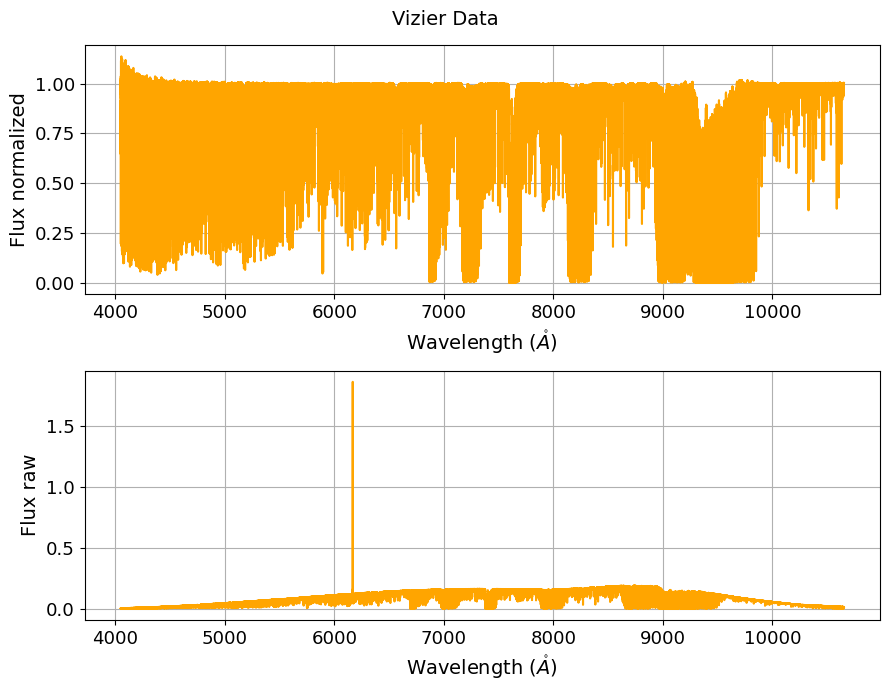

In [44]:
#Plot of raw data
fig1, axis1 = plt.subplots(2,1, figsize = (9, 7),)
ax1 = axis1[0]
ax2 = axis1[1]

fig1.suptitle(r'Vizier Data',fontsize=14)

ax1.plot(raw_data['Wave A'],raw_data['nFlux'],color='orange')
ax1.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax1.set_ylabel('Flux normalized',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.plot(raw_data['Wave A'],raw_data['rFlux'],color='orange')
ax2.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax2.set_ylabel('Flux raw',fontsize=14)
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)

fig1.tight_layout()

### Wavelength classification

In [45]:
#between work like < or > but not the equal, reset the index for the other functions
data_4000_5000 = raw_data[raw_data['Wave A'].between(4000, 5000, inclusive='neither')].reset_index(drop=True)
data_5000_6000 = raw_data[raw_data['Wave A'].between(5000, 6000, inclusive='neither')].reset_index(drop=True)
data_6000_7000 = raw_data[raw_data['Wave A'].between(6000, 7000, inclusive='neither')].reset_index(drop=True)
data_7000_8000 = raw_data[raw_data['Wave A'].between(7000, 8000, inclusive='neither')].reset_index(drop=True)
data_8000_9000 = raw_data[raw_data['Wave A'].between(8000, 9000, inclusive='neither')].reset_index(drop=True)
data_9000_10000 = raw_data[raw_data['Wave A'].between(9000, 10000, inclusive='neither')].reset_index(drop=True)
data_10000_11000 = raw_data[raw_data['Wave A'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)


data_4000_5000

,Wave (cm),nFlux,rFlux,Wave A
0,24700.085804,0.913045,0.002181,4048.568932
1,24700.082038,0.911843,0.002247,4048.569549
2,24700.078271,0.883065,0.002311,4048.570167
3,24700.074505,0.862602,0.002342,4048.570784
4,24700.070738,0.867600,0.002327,4048.571401
...,...,...,...,...
1247850,20000.015768,0.992487,0.043338,4999.996058
1247851,20000.012002,0.993481,0.043338,4999.997000
1247852,20000.008235,0.994571,0.043319,4999.997941
1247853,20000.004469,0.994641,0.043292,4999.998883


In [46]:
#Now from lambda
lambda_4000_5000 = raw_lambda[raw_lambda['lambda'].between(4000, 5000, inclusive='neither')].reset_index(drop=True)
lambda_5000_6000 = raw_lambda[raw_lambda['lambda'].between(5000, 6000, inclusive='neither')].reset_index(drop=True)
lambda_6000_7000 = raw_lambda[raw_lambda['lambda'].between(6000, 7000, inclusive='neither')].reset_index(drop=True)
lambda_7000_8000 = raw_lambda[raw_lambda['lambda'].between(7000, 8000, inclusive='neither')].reset_index(drop=True)
lambda_8000_9000 = raw_lambda[raw_lambda['lambda'].between(8000, 9000, inclusive='neither')].reset_index(drop=True)
lambda_9000_10000 = raw_lambda[raw_lambda['lambda'].between(9000, 10000, inclusive='neither')].reset_index(drop=True)
lambda_10000_11000 = raw_lambda[raw_lambda['lambda'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)


lambda_4000_5000

,lambda
0,4056.1809
1,4059.9003
2,4060.8601
3,4063.5882
4,4067.7336
...,...
270,4986.9382
271,4987.6138
272,4990.3419
273,4992.6608


### Find the minimums and the closer line of the Fe I line


In [47]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #take all the row

    #Dataframe with the marks for the closer lines of Fe
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda
    
    #Use the IQR method for a better research for outliers
    Q1 = np.percentile(closer_data['abs'], 25, method = 'midpoint') 
    Q3 = np.percentile(closer_data['abs'], 75, method = 'midpoint')
    IQR = Q3 - Q1

    #Take a conditional for the outliers, False is Outlier
    closer_data['Outliers']= closer_data['abs'].between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR, inclusive='neither')

    return closer_data.drop(['abs'],axis=1)

closer_lines_4000_5000= find_minimums(data_4000_5000['Wave A'],data_4000_5000['nFlux'],lambda_4000_5000['lambda'])
closer_lines_5000_6000 = find_minimums(data_5000_6000['Wave A'],data_5000_6000['nFlux'],lambda_5000_6000['lambda'])
closer_lines_6000_7000 = find_minimums(data_6000_7000['Wave A'],data_6000_7000['nFlux'],lambda_6000_7000['lambda'])
closer_lines_7000_8000 = find_minimums(data_7000_8000['Wave A'],data_7000_8000['nFlux'],lambda_7000_8000['lambda'])
closer_lines_8000_9000 = find_minimums(data_8000_9000['Wave A'],data_8000_9000['nFlux'],lambda_8000_9000['lambda'])
closer_lines_9000_10000 = find_minimums(data_9000_10000['Wave A'],data_9000_10000['nFlux'],lambda_9000_10000['lambda'])
closer_lines_10000_11000 = find_minimums(data_10000_11000['Wave A'],data_10000_11000['nFlux'],lambda_10000_11000['lambda'])


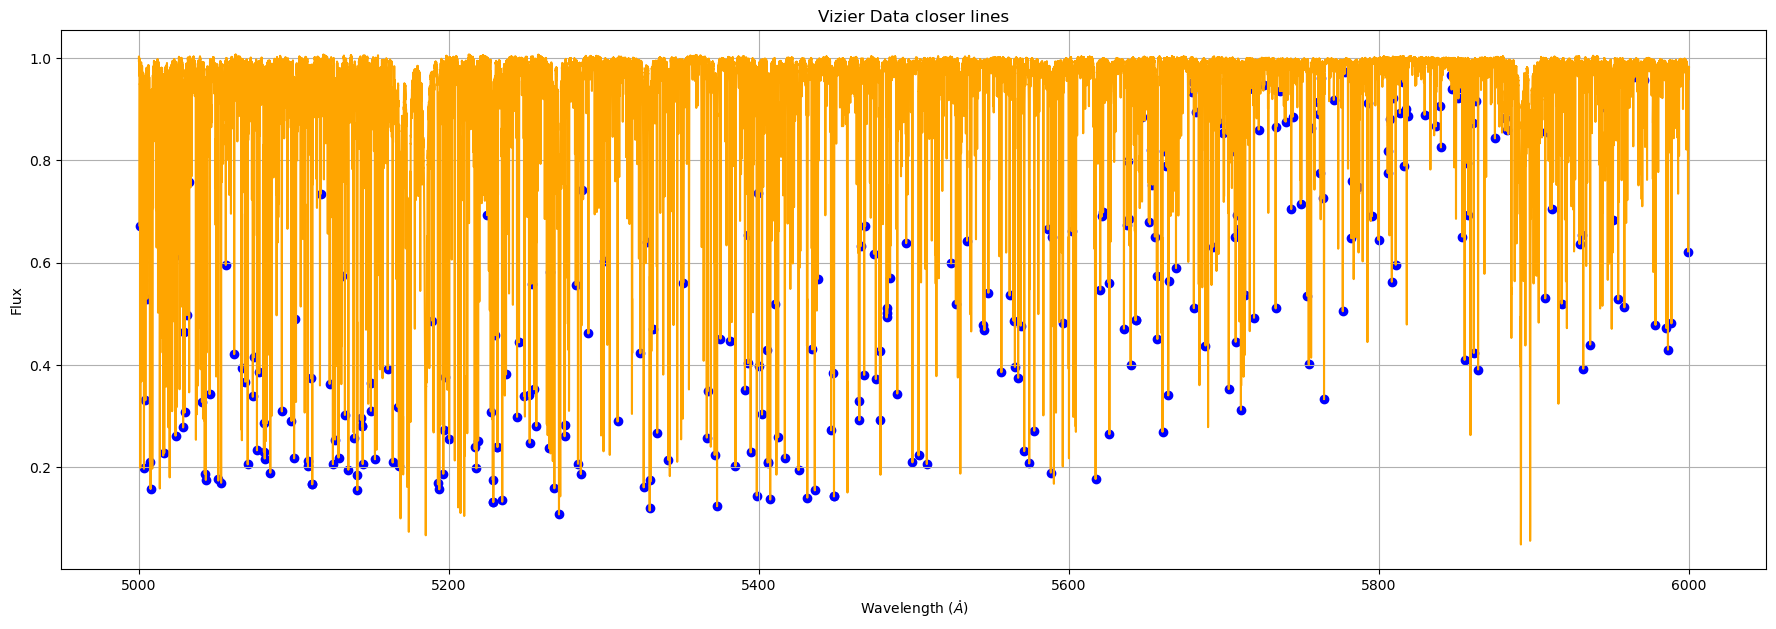

In [48]:
fig3, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(data_5000_6000['Wave A'],data_5000_6000['nFlux'], color='orange')
ax.scatter(closer_lines_5000_6000['min_wave'],closer_lines_5000_6000['min_flux'], color='blue')
ax.set_title('Vizier Data closer lines')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

In [49]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

#Data
local_points_4000_5000 = width_minimums(closer_lines_4000_5000,data_4000_5000,0.05)
local_points_5000_6000 = width_minimums(closer_lines_5000_6000,data_5000_6000,0.05)
local_points_6000_7000 = width_minimums(closer_lines_6000_7000,data_6000_7000,0.05)
local_points_7000_8000 = width_minimums(closer_lines_7000_8000,data_7000_8000,0.05)
local_points_8000_9000 = width_minimums(closer_lines_8000_9000,data_8000_9000,0.05)
local_points_9000_10000 = width_minimums(closer_lines_9000_10000,data_9000_10000,0.05)
local_points_10000_11000 = width_minimums(closer_lines_10000_11000,data_10000_11000,0.05)


In [50]:
outliers_4000_5000 = closer_lines_4000_5000[closer_lines_4000_5000['Outliers']==False].drop(['Outliers'],axis=1)
index_outliers_4000_5000 = outliers_4000_5000.index.values
local_points_outliers_4000_5000 = [local_points_4000_5000[i] for i in index_outliers_4000_5000 ]

### Check the outliers manually - Visualizer

In [51]:
# import tkinter as tk
# from tkinter import ttk
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
# import numpy as np

# class OutlierViewer:
#     def __init__(self, root, local_points_outliers, outliers):
#         self.root = root
#         self.root.title("Visualizador Interactivo de Outliers")
#         self.local_points_outliers = local_points_outliers
#         self.outliers = outliers
#         self.index = outliers.index.values
#         self.current_index = 0
       
#         self.setup_ui()
#         self.update_plot()
    
#     def setup_ui(self):
#         main_frame = ttk.Frame(self.root, padding="10")
#         main_frame.pack(fill=tk.BOTH, expand=True)
        
#         control_frame = ttk.Frame(main_frame)
#         control_frame.pack(fill=tk.X, pady=10)
        
#         ttk.Label(control_frame, text="Índice de Outlier:").pack(side=tk.LEFT, padx=5)
#         self.slider = ttk.Scale(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             orient=tk.HORIZONTAL,
#             command=self.on_slider_move
#         )
#         self.slider.pack(side=tk.LEFT, expand=True, fill=tk.X, padx=5)
        
#         self.spinbox = ttk.Spinbox(
#             control_frame,
#             from_=0,
#             to=len(self.index)-1,
#             width=5,
#             command=self.on_spinbox_change
#         )
#         self.spinbox.pack(side=tk.LEFT, padx=5)
#         self.spinbox.bind("<Return>", self.on_spinbox_change)
        
#         nav_frame = ttk.Frame(control_frame)
#         nav_frame.pack(side=tk.LEFT, padx=10)
        
#         ttk.Button(nav_frame, text="← Anterior", command=self.prev_plot).pack(side=tk.LEFT)
#         ttk.Button(nav_frame, text="Siguiente →", command=self.next_plot).pack(side=tk.LEFT, padx=5)
     
#         graph_frame = ttk.Frame(main_frame)
#         graph_frame.pack(fill=tk.BOTH, expand=True)
       
#         self.fig, self.ax = plt.subplots(figsize=(10, 6))
#         self.canvas = FigureCanvasTkAgg(self.fig, master=graph_frame)
#         self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
#         self.toolbar = NavigationToolbar2Tk(self.canvas, graph_frame)
#         self.toolbar.update()
#         self.canvas._tkcanvas.pack(fill=tk.BOTH, expand=True)
    
#     def on_slider_move(self, event=None):
#         self.current_index = int(float(self.slider.get()))
#         self.spinbox.delete(0, tk.END)
#         self.spinbox.insert(0, str(self.current_index))
#         self.update_plot()
    
#     def on_spinbox_change(self, event=None):
#         try:
#             new_index = int(self.spinbox.get())
#             if 0 <= new_index < len(self.index):
#                 self.current_index = new_index
#                 self.slider.set(self.current_index)
#                 self.update_plot()
#         except ValueError:
#             pass
    
#     def prev_plot(self):
#         if self.current_index > 0:
#             self.current_index -= 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     def next_plot(self):
#         if self.current_index < len(self.index)-1:
#             self.current_index += 1
#             self.slider.set(self.current_index)
#             self.spinbox.delete(0, tk.END)
#             self.spinbox.insert(0, str(self.current_index))
#             self.update_plot()
    
#     def update_plot(self):
#         j = self.current_index
#         self.ax.clear()
        
#         # Gráfica principal
#         self.ax.plot(
#             self.local_points_outliers[j]['Wave A'],
#             self.local_points_outliers[j]['nFlux'],
#             color='orange',
#             label='Espectro'
#         )
        
#         # Puntos destacados
#         self.ax.scatter(
#             self.outliers['min_wave'][self.index[j]],
#             self.outliers['min_flux'][self.index[j]],
#             color='red',
#             label='Outliers',
#             s=100
#         )
        
#         self.ax.scatter(
#             self.outliers['Fe line'][self.index[j]],
#             self.outliers['min_flux'][self.index[j]],
#             color='blue',
#             label='Fe lines',
#             s=100
#         )
        
#         # Configuración del gráfico
#         self.ax.set_title(f'Outliers - Índice {self.index[j]}')
#         self.ax.set_xlabel(r'Wavelength $(\mathring{A})$')
#         self.ax.set_ylabel('Flux')
#         self.ax.legend()
#         self.ax.grid(True)
        
#         self.canvas.draw()


# if __name__ == "__main__":
#     root = tk.Tk()
#     root.geometry("900x700")

#     app = OutlierViewer(root, local_points_outliers_4000_5000, outliers_4000_5000)
#     # app = OutlierViewer(root, local_points_outliers_5000_6000, outliers_5000_6000)
#     # app = OutlierViewer(root, local_points_outliers_6000_7000, outliers_6000_7000)
#     # app = OutlierViewer(root, local_points_outliers_7000_8000, outliers_7000_8000)
#     # app = OutlierViewer(root, local_points_outliers_8000_9000, outliers_8000_9000)
#     #app = OutlierViewer(root, local_points_outliers_9000_10000, outliers_9000_10000)
#     # app = OutlierViewer(root, local_points_outliers_10000_11000, outliers_10000_11000) #None

#     root.mainloop()

### Define the lines without outliers

In [52]:
#Index for drop outliers. Enter manually 
index_to_drop_4000_5000 = np.array([200,244])
index_to_drop_5000_6000 = np.array([40,54,77,130,143,195])
index_to_drop_6000_7000 = np.array([46])
index_to_drop_7000_8000 = np.array([43])
index_to_drop_8000_9000 = np.array([22])
index_to_drop_9000_10000 = np.array([7,18])
index_to_drop_10000_11000 = np.array([])

#The local points without outliers
points_4000_5000 = [local_points_4000_5000[i] for i in range(0,len(local_points_4000_5000)) if i not in index_to_drop_4000_5000]
points_5000_6000 = [local_points_5000_6000[i] for i in range(0,len(local_points_5000_6000)) if i not in index_to_drop_5000_6000]
points_6000_7000 = [local_points_6000_7000[i] for i in range(0,len(local_points_6000_7000)) if i not in index_to_drop_6000_7000] 
points_7000_8000 = [local_points_7000_8000[i] for i in range(0,len(local_points_7000_8000)) if i not in index_to_drop_7000_8000]
points_8000_9000 = [local_points_8000_9000[i] for i in range(0,len(local_points_8000_9000)) if i not in index_to_drop_8000_9000]
points_9000_10000 = [local_points_9000_10000[i] for i in range(0,len(local_points_9000_10000)) if i not in index_to_drop_9000_10000]
points_10000_11000 = [local_points_10000_11000[i] for i in range(0,len(local_points_10000_11000)) if i not in index_to_drop_10000_11000]

#Lambda witout the outliers
lamda_4000_5000 = lambda_4000_5000.drop(index_to_drop_4000_5000).reset_index(drop=True)
lamda_5000_6000 = lambda_5000_6000.drop(index_to_drop_5000_6000).reset_index(drop=True)
lamda_6000_7000 = lambda_6000_7000.drop(index_to_drop_6000_7000).reset_index(drop=True)
lamda_7000_8000 = lambda_7000_8000.drop(index_to_drop_7000_8000).reset_index(drop=True)
lamda_8000_9000 = lambda_8000_9000.drop(index_to_drop_8000_9000).reset_index(drop=True)
lamda_9000_10000 = lambda_9000_10000.drop(index_to_drop_9000_10000).reset_index(drop=True)
lamda_10000_11000 = lambda_10000_11000.drop(index_to_drop_10000_11000).reset_index(drop=True)


### Derivates and fit

In [53]:
def Fit_derivates(local_points,lamda_list):
    values = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of lines 

        #Internal rise, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #take the conditional for the division

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0:
            value_roots = pol(valid_roots) #evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #take the values

            #For the lambda convert the minimal root in wave with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,3), minimal_root[1]]

            #Evaluate the second and third derivate in the lambda observed
            #Formula for the third derivate
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))

            d2 = poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2) #Re-scalated the coefficients
            d3 = Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) ) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

    
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2,d3,blueshift]])) #natural lambda, observed lambda, flux, velocity, second derivate, third derivate

    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Lambda natural", "Lambda observed", "Flux",'Velocity','2nd Derivate','3rd Derivate','Blueshift']


    return Values

Values_4000_5000 = Fit_derivates(points_4000_5000,lamda_4000_5000['lambda'])
Values_5000_6000 = Fit_derivates(points_5000_6000,lamda_5000_6000['lambda'])
Values_6000_7000 = Fit_derivates(points_6000_7000,lamda_6000_7000['lambda'])
Values_7000_8000 = Fit_derivates(points_7000_8000,lamda_7000_8000['lambda'])
Values_8000_9000 = Fit_derivates(points_8000_9000,lamda_8000_9000['lambda'])
Values_9000_10000 = Fit_derivates(points_9000_10000,lamda_9000_10000['lambda'])
Values_10000_11000 = Fit_derivates(points_10000_11000,lamda_10000_11000['lambda'])

In [54]:
Values = pd.concat([Values_4000_5000, Values_5000_6000, Values_6000_7000, Values_7000_8000, Values_8000_9000, Values_9000_10000, Values_10000_11000],axis=0).reset_index(drop=True)
Values = Values.drop([288,920],axis=0)


In [55]:

#separate for color range, make a list
values_colors = [ Values[Values['Lambda observed'].between(3800, 4270, inclusive='neither')],
                 Values[Values['Lambda observed'].between(4270, 4760, inclusive='neither')],
                 Values[Values['Lambda observed'].between(4760, 4970, inclusive='neither')],
                 Values[Values['Lambda observed'].between(4970, 5700, inclusive='neither')],
                 Values[Values['Lambda observed'].between(5700, 5810, inclusive='neither')],
                 Values[Values['Lambda observed'].between(5810, 6180, inclusive='neither')],
                 Values[Values['Lambda observed'].between(6180, 7800, inclusive='neither')],
                 Values[Values['Lambda observed'].between(7800, 11000, inclusive='neither')]
]

In [56]:
#Convert to excel
# Values.to_excel('valores_VIS.xlsx', index=False)

### Graphics 

In [57]:
#colors for the plot
colors = ['violet','blue','cyan','green','yellow','orange','red','brown']

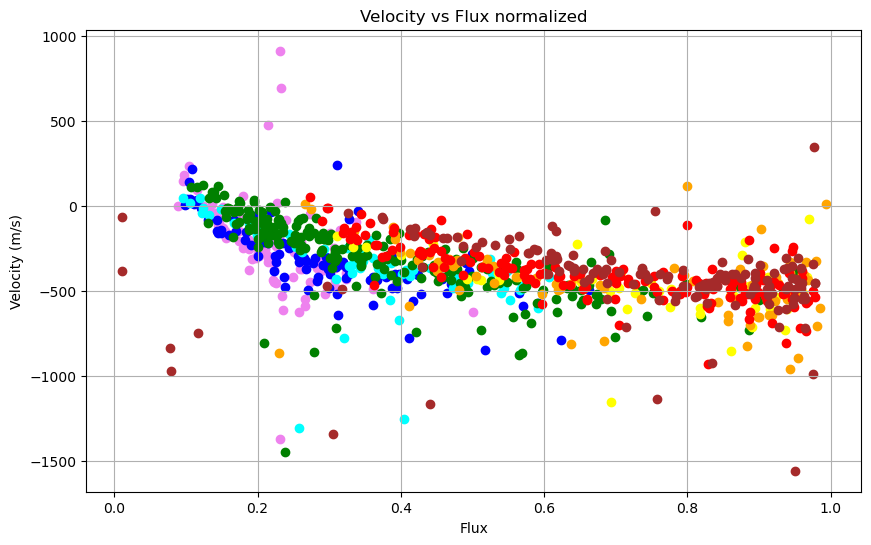

In [58]:
#Velocity vs Flux 
fig5, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['Velocity'], c=colors[i])

ax.set_title('Velocity vs Flux normalized')
ax.set_xlabel(r'Flux')
ax.set_ylabel('Velocity (m/s)')
ax.grid()

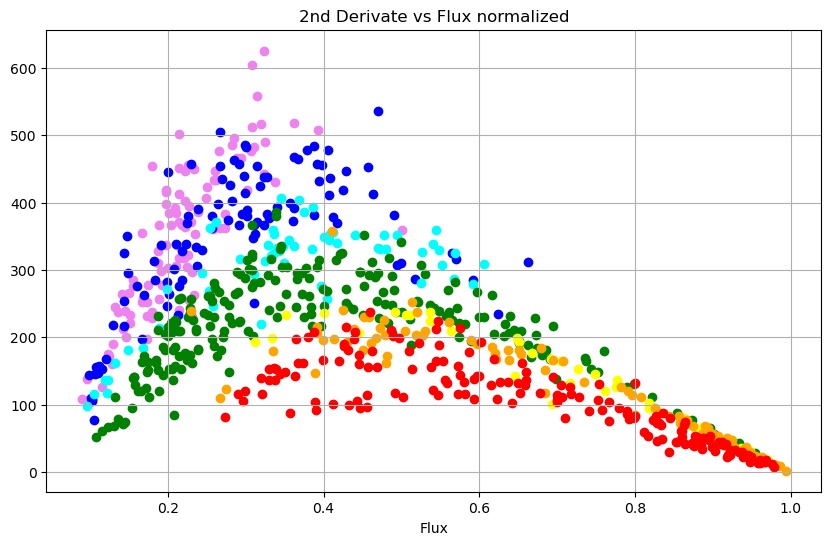

In [59]:
#2nd Derivate vs Flux
fig6, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)-1):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['2nd Derivate'], color=colors[i])

ax.set_title('2nd Derivate vs Flux normalized')
ax.set_xlabel(r'Flux')
ax.grid()

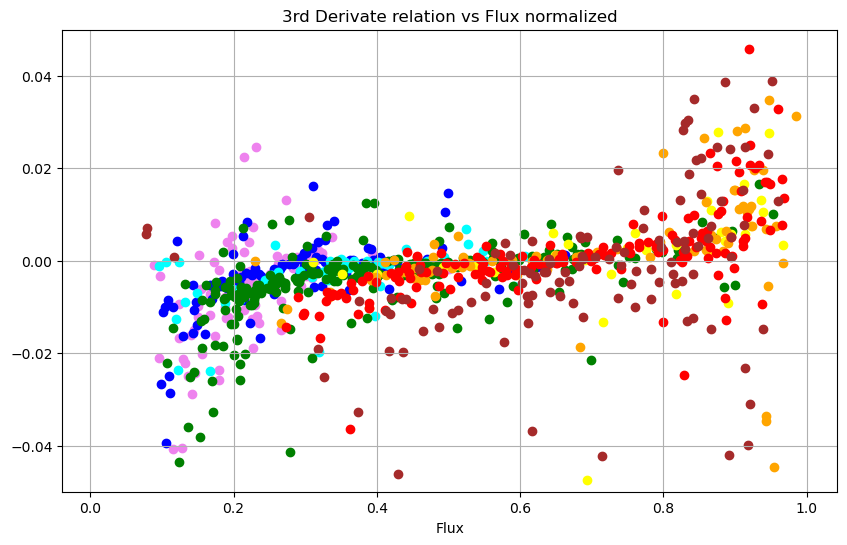

In [60]:
#3rd Derivate vs Flux
fig6, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['3rd Derivate'], color=colors[i])

ax.set_title('3rd Derivate relation vs Flux normalized')
ax.set_xlabel(r'Flux')
ax.set_ylim(-0.05,0.05)
ax.grid()

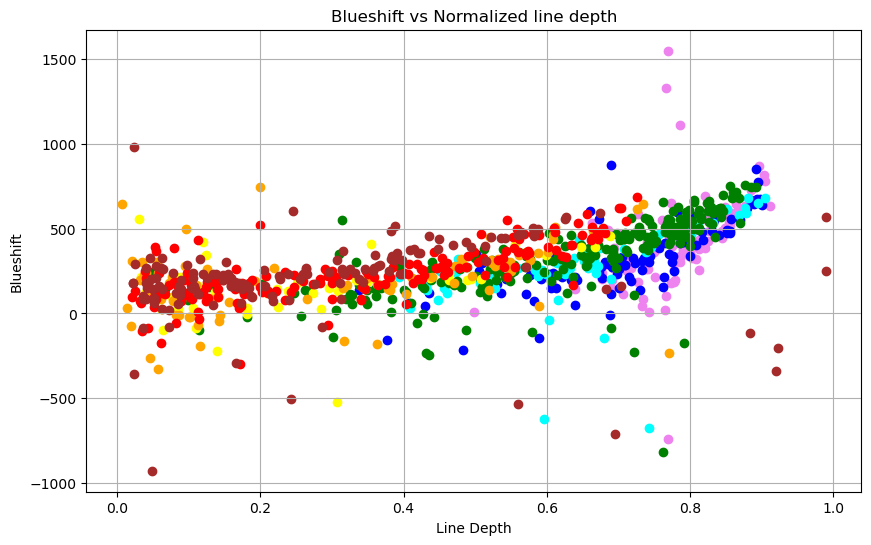

In [61]:
#Granulation pattern
fig7, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(1-values_colors[i]['Flux'],values_colors[i]['Blueshift'], color=colors[i])

ax.set_title('Blueshift vs Normalized line depth')
ax.set_xlabel(r'Line Depth')
ax.set_ylabel(r'Blueshift')

ax.grid()